In [6]:
! pip install tb-nightly

     |████████████████████████████████| 5.8 MB 6.2 MB/s eta 0:00:01
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached Werkzeug-2.0.2-py3-none-any.whl (288 kB)
  Using cached Markdown-3.3.6-py3-none-any.whl (97 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached grpcio-1.42.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.0 MB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached google_auth-2.3.3-py2.py3-none-any.whl (155 kB)
  Using cached protobuf-3.19.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached cachetools-4.2.4-py3-none-any.whl (10 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.4.8-py2

In [44]:
!pip install seaborn


     |████████████████████████████████| 292 kB 12.2 MB/s eta 0:00:01


In [52]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
import pdb
import seaborn as sns
import itertools

In [8]:
class CNN(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16*7*7, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x
    

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device)

device= cuda


In [32]:
# Hyperparameters
# При подборе гиперпараметров в первой части задания лучшие результаты были при (bs=2, lr=0.001) и (bs=64, lr=0.01)
# Я выбираю второй вариант, так как при большем батче быстрее учится

learning_rate = 0.01
in_channels = 1
num_classes  =10
batch_size = 64
num_epochs = 3


In [33]:
train_dataset = datasets.MNIST(root='dataset/', train=True, 
                              transform=transforms.ToTensor(), download=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [62]:
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

def image_grid(class_names, train_images, train_labels, predictions):
  """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
  # Create a figure to contain the plot.
  figure = plt.figure(figsize=(12,12))
  for i in range(25):
    # Start next subplot.
    plt.subplot(5, 5, i + 1, title=f"g={class_names[train_labels[i]]}/p={class_names[predictions[i]]}")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].squeeze(), cmap=plt.cm.binary)

  return figure

Mean loss in this epoch was 0.1503235471173267


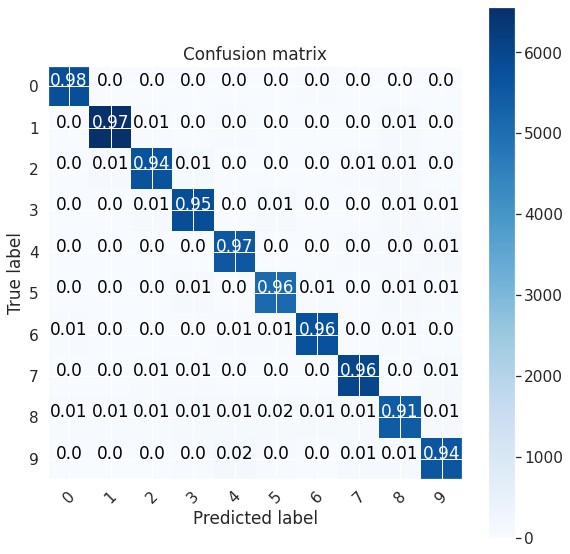

Mean loss in this epoch was 0.06006350696669208


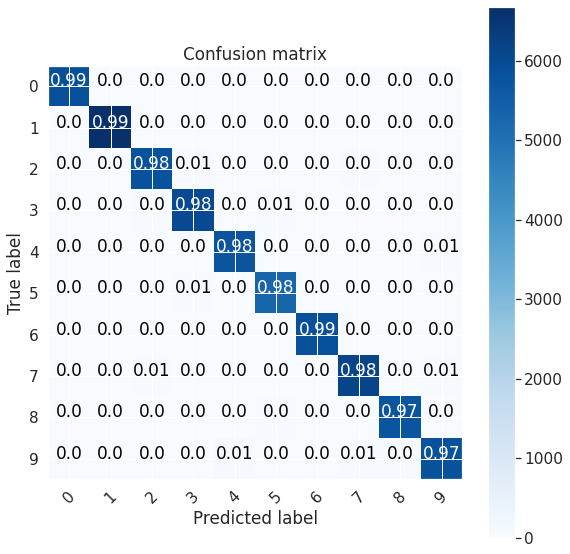

Mean loss in this epoch was 0.05001972204951474


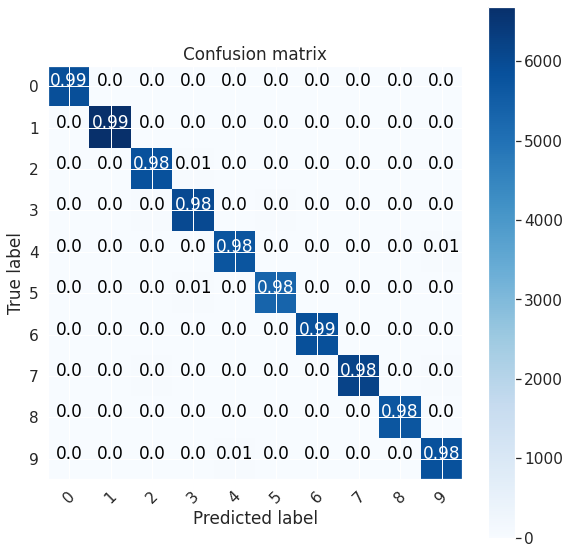

In [63]:
model = CNN(in_channels=in_channels, num_classes=num_classes)
model.to(device)
model.train()
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)
writer = SummaryWriter(f'runs/MNIST/MiniBatchSize {batch_size} LR {learning_rate}')

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
step = 0
for epoch in range(num_epochs):
    losses = []
    accuracies = []
    all_predictions = [] #сюда я буду собирать все предсказания за эпоху, чтобы в конце эпохи построить матрицу ошибок
    all_targets = []

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        #forward
        scores = model(data)
        loss = criterion(scores, targets)
        losses.append(loss.item())

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate 'running' training accuracy
        #img_grid = torchvision.utils.make_grid(data)
        #writer.add_image('mnist_images', img_grid, global_step = step)
        #writer.add_histogram('fc1', model.fc1.weight, global_step = step)
        _, predictions = scores.max(1)
        num_correct = (predictions == targets).sum()
        running_train_acc = float(num_correct) / float(data.shape[0])
        accuracies.append(running_train_acc)
        
        all_predictions.extend(predictions.cpu())
        all_targets.extend(targets.cpu())
        
        if batch_idx == 230:
            fig = image_grid(class_names, data.cpu(), targets.cpu(), predictions.cpu())
            writer.add_figure('examples', fig, global_step = step)
        
        writer.add_scalar('Training loss', loss, global_step = step)
        writer.add_scalar('Training accuracy', running_train_acc, global_step=step)
        step += 1

    print(f'Mean loss in this epoch was {sum(losses)/len(losses)}')
    conf_mat = confusion_matrix(all_predictions, all_targets)
    
    fig = plot_confusion_matrix(conf_mat, class_names)
    plt.show()
    #pdb.set_trace()
    writer.add_figure('confusion_matrix', fig, global_step = step)